In [2]:
!pip install -q feature_engine

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings 
warnings.filterwarnings("ignore")

import shap
import matplotlib.pyplot as plt
from catboost import Pool, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
import ast

pd.set_option('display.max_rows', 1000)

In [4]:
df = pd.read_csv(r"C:\Users\dell\Desktop\MyDocs\Docs\MK\salaries_n.csv")
item0 = df.shape[0]
df = df.drop_duplicates()
item1 = df.shape[0]
print(f"Removed {item0-item1} full duplicates")
print(df.shape)

Removed 37 full duplicates
(2645, 8)


In [5]:
df.sample(3).T

,1377,1395,1672
kjønn,mann,mann,mann
utdanning,3,3,3
erfaring,6,2,7
arbeidssted,Vestland,Vestland,Oslo
arbeidssituasjon,"in-house, privat sektor","in-house, privat sektor",konsulent
fag,frontend,frontend,fullstack
lønn,750000,675000,975000
bonus?,Ja,Ja,Nei


In [6]:
# select main label
main_label = 'lønn'
# Convert compensations into kNOK/year
df[main_label] = df[main_label]*1e-3
# further exclude 2% of smallest and 2% of highest salaries
P = np.percentile(df[main_label], [2, 98])
df = df[(df[main_label] > P[0]) & (df[main_label] < P[1])]

print(df.shape)

(2526, 8)


In [7]:
df["kjønn"].value_counts()

kjønn
mann                         2156
kvinne                        354
annet / ønsker ikke oppgi      16
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2526 entries, 0 to 2681
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kjønn             2526 non-null   object 
 1   utdanning         2526 non-null   int64  
 2   erfaring          2526 non-null   int64  
 3   arbeidssted       2526 non-null   object 
 4   arbeidssituasjon  2526 non-null   object 
 5   fag               2526 non-null   object 
 6   lønn              2526 non-null   float64
 7   bonus?            2526 non-null   object 
dtypes: float64(1), int64(2), object(5)
memory usage: 177.6+ KB


In [9]:
for col in df.columns:
    if col != main_label:
        print("Rare encode column", col)
        df[col] = df[col].fillna('None').astype(str)
        encoder = RareLabelEncoder(n_categories=1, max_n_categories=120, replace_with='Other', tol=10/df.shape[0])
        df[col] = encoder.fit_transform(df[[col]])

print(df.shape)

Rare encode column kjønn
Rare encode column utdanning
Rare encode column erfaring
Rare encode column arbeidssted
Rare encode column arbeidssituasjon
Rare encode column fag
Rare encode column bonus?
(2526, 8)


In [10]:
df.sample(3).T

,1836,591,2445
kjønn,mann,mann,mann
utdanning,5,3,6
erfaring,3,2,7
arbeidssted,Oslo,Oslo,Vestland
arbeidssituasjon,konsulent,konsulent,konsulent
fag,fullstack,backend,ledelse/administrativt
lønn,800.0,724.0,850.0
bonus?,Nei,Ja,Ja


In [11]:
# initialize data
y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=df['kjønn'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1263, 7), (1263, 7), (1263,), (1263,))

In [12]:
%%time
# initialize Pool
train_pool = Pool(X_train, 
                  y_train, 
                  cat_features=cat_cols_idx)
test_pool = Pool(X_test,
                 y_test,
                 cat_features=cat_cols_idx)
# specify the training parameters 
model = CatBoostRegressor(iterations=10_000, # Number of boosting iteration
                          depth=10, # Maximum depth of trees in the ensemble
                          verbose=0, # Set verbosity level to 0 (no output during training)
                          early_stopping_rounds=100, # Early stopping rounds
                          learning_rate=0.01, # Learning rate for gradient boosting
                          loss_function='RMSE')
# train the model
model.fit(train_pool, eval_set=test_pool)
# make the prediction using the resulting model
y_train_pred = model.predict(train_pool)
y_test_pred = model.predict(test_pool)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
print(f"RMSE score for train {round(rmse_train,2)} kNOK/year, and for test {round(rmse_test,2)} kNOK/year")

RMSE score for train 130.8 kNOK/year, and for test 154.48 kNOK/year
CPU times: total: 21.7 s
Wall time: 38.4 s


In [13]:
rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for train {round(rmse_bs_train,1)} kNOK/year, and for test {round(rmse_bs_test,1)} kNOK/year")

RMSE baseline score for train 224.3 kNOK/year, and for test 228.7 kNOK/year


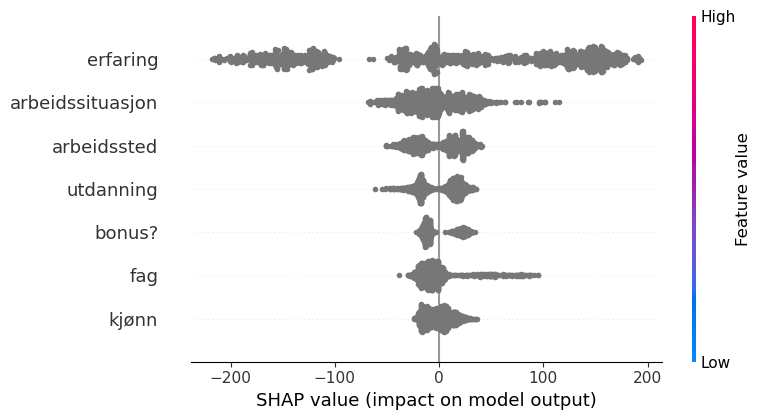

CPU times: total: 9min 3s
Wall time: 1min 24s


In [14]:
%%time
shap.initjs()
ex = shap.TreeExplainer(model)
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

In [15]:
expected_values = ex.expected_value
print(f"Average predicted salary is {round(expected_values,1)} kNOK/year")
print(f"Average actual salary is {round(np.mean(y_test),1)} kNOK/year")

Average predicted salary is 882.6 kNOK/year
Average actual salary is 889.1 kNOK/year



kjønn



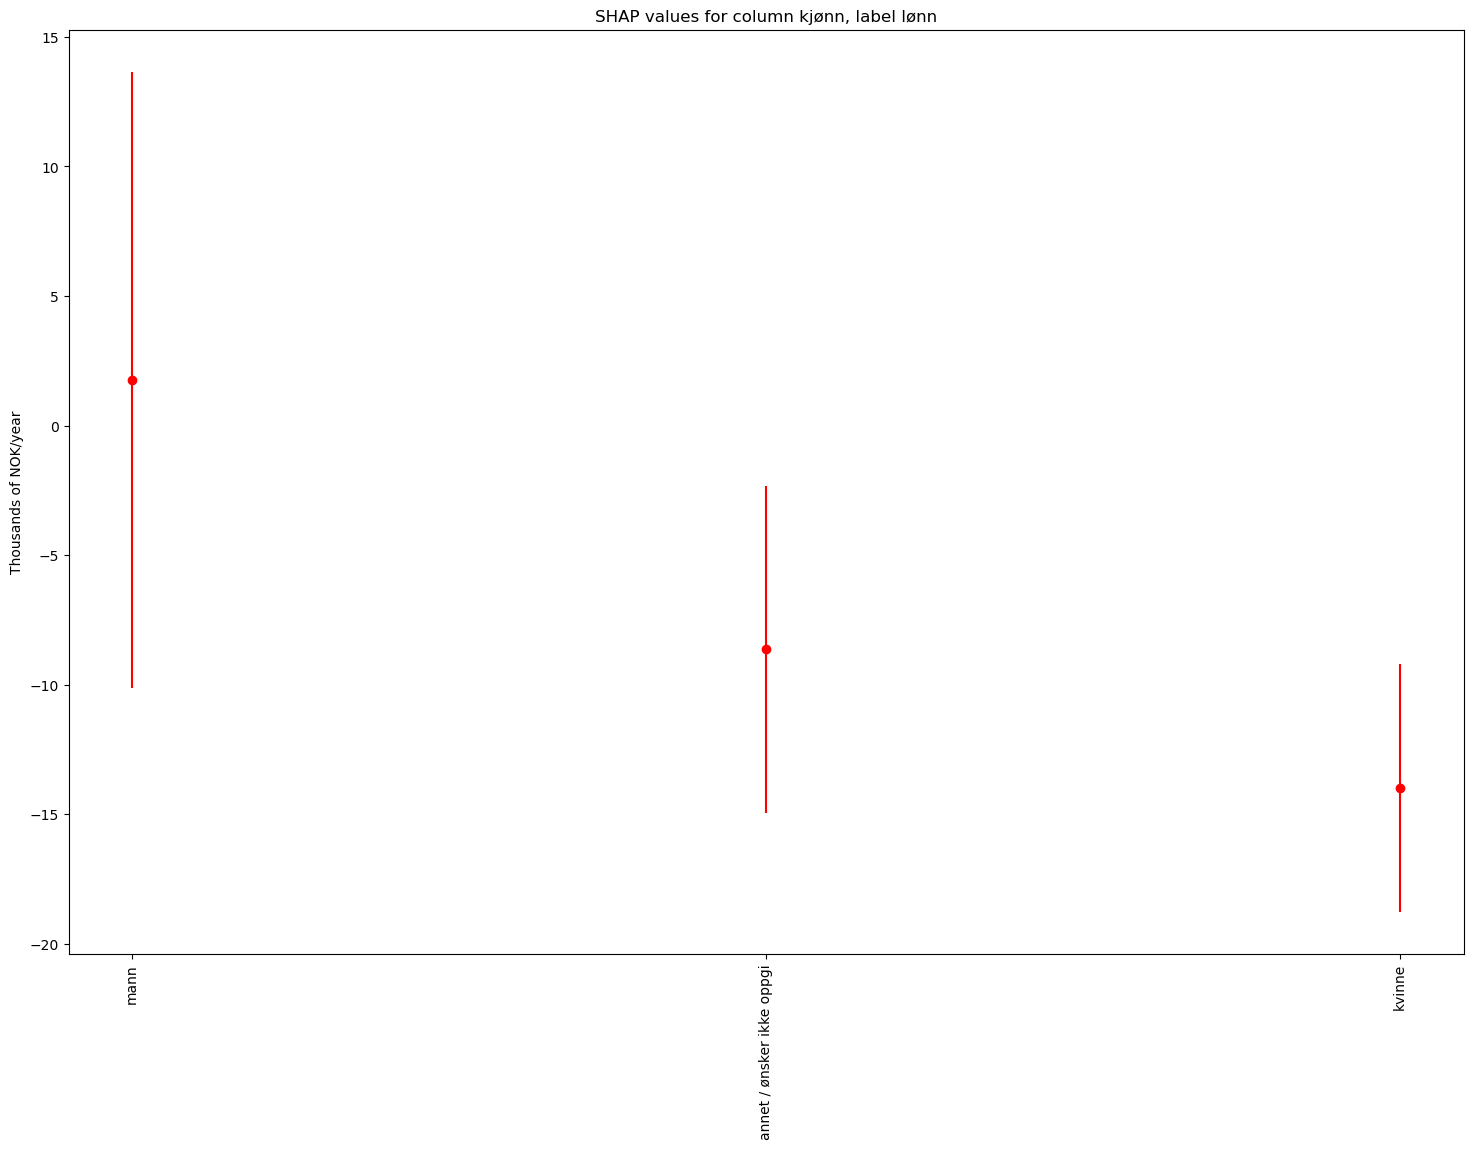

                              gain  gain_std  count
col                                                
mann                        1.7577   11.8949   1078
annet / ønsker ikke oppgi  -8.6397    6.3049      8
kvinne                    -13.9698    4.7859    177

utdanning



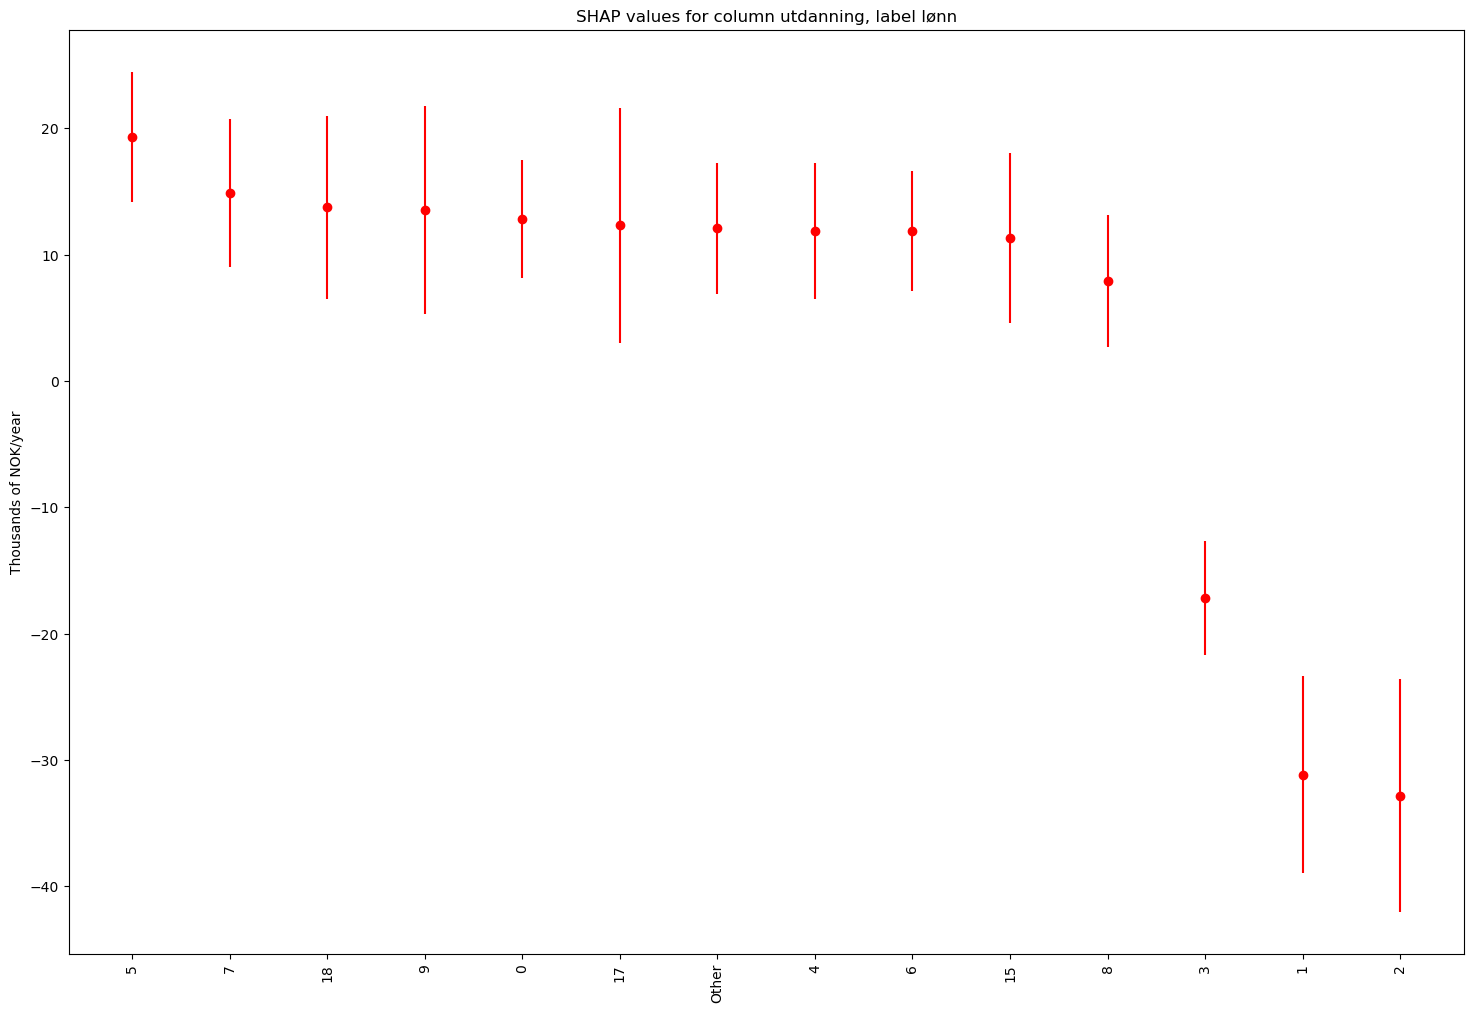

          gain  gain_std  count
col                            
5      19.3138    5.1496    433
7      14.8983    5.8682     10
18     13.7385    7.2227      8
9      13.5339    8.2605      4
0      12.8168    4.6964     82
17     12.3085    9.3340     10
Other  12.0757    5.2032     17
4      11.8828    5.3972     84
6      11.8474    4.7387     46
15     11.3180    6.7014      8
8       7.9042    5.1996      9
3     -17.1904    4.4986    467
1     -31.1733    7.7928     28
2     -32.8101    9.2133     57

erfaring



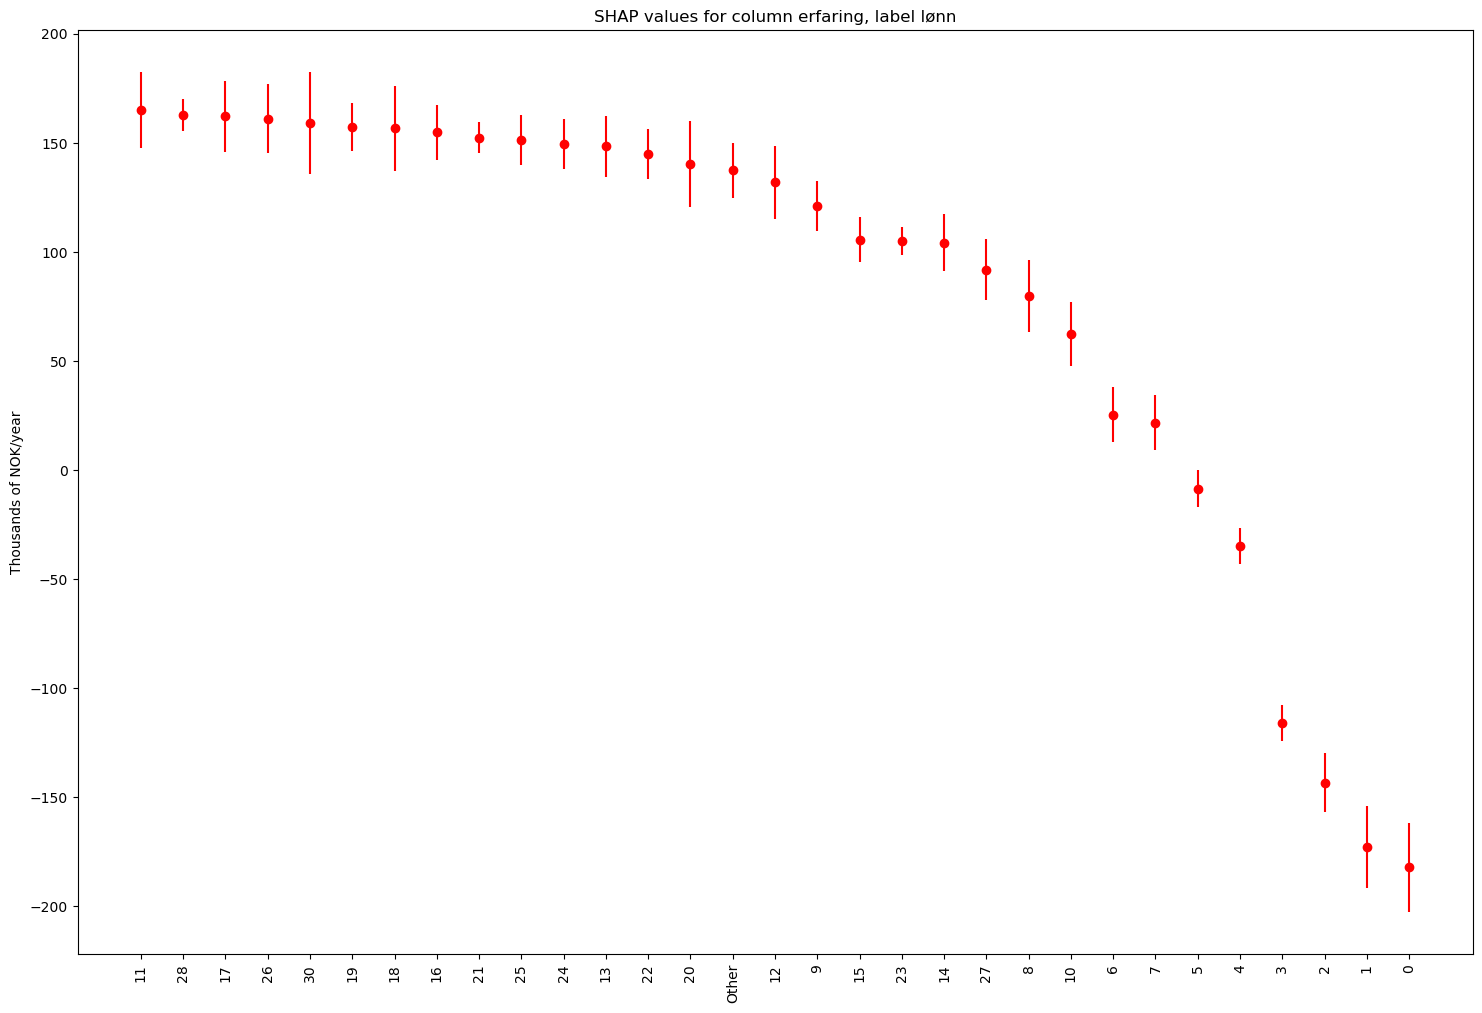

           gain  gain_std  count
col                             
11     164.8681   17.5210     29
28     162.6765    7.2682      5
17     162.0107   16.1812     28
26     161.0016   15.9203      8
30     159.0321   23.3712     12
19     157.1121   11.1197     16
18     156.4691   19.6712     21
16     154.6418   12.5018     25
21     152.2411    7.0503      8
25     151.3670   11.4391     25
24     149.2237   11.4268     18
13     148.3458   13.9382     22
22     144.7528   11.2652      6
20     140.1711   19.8848     36
Other  137.3777   12.5983     13
12     131.7275   16.6129     48
9      120.7611   11.4261     31
15     105.4754   10.3977     34
23     104.6881    6.4172     11
14     104.1670   12.9585     31
27      91.6679   13.9402      7
8       79.6009   16.3694     38
10      62.1830   14.6744     52
6       25.2500   12.6603     66
7       21.6502   12.7540     59
5       -8.5385    8.5442    130
4      -34.8554    8.0709    103
3     -116.0542    8.1694    105
2     -143

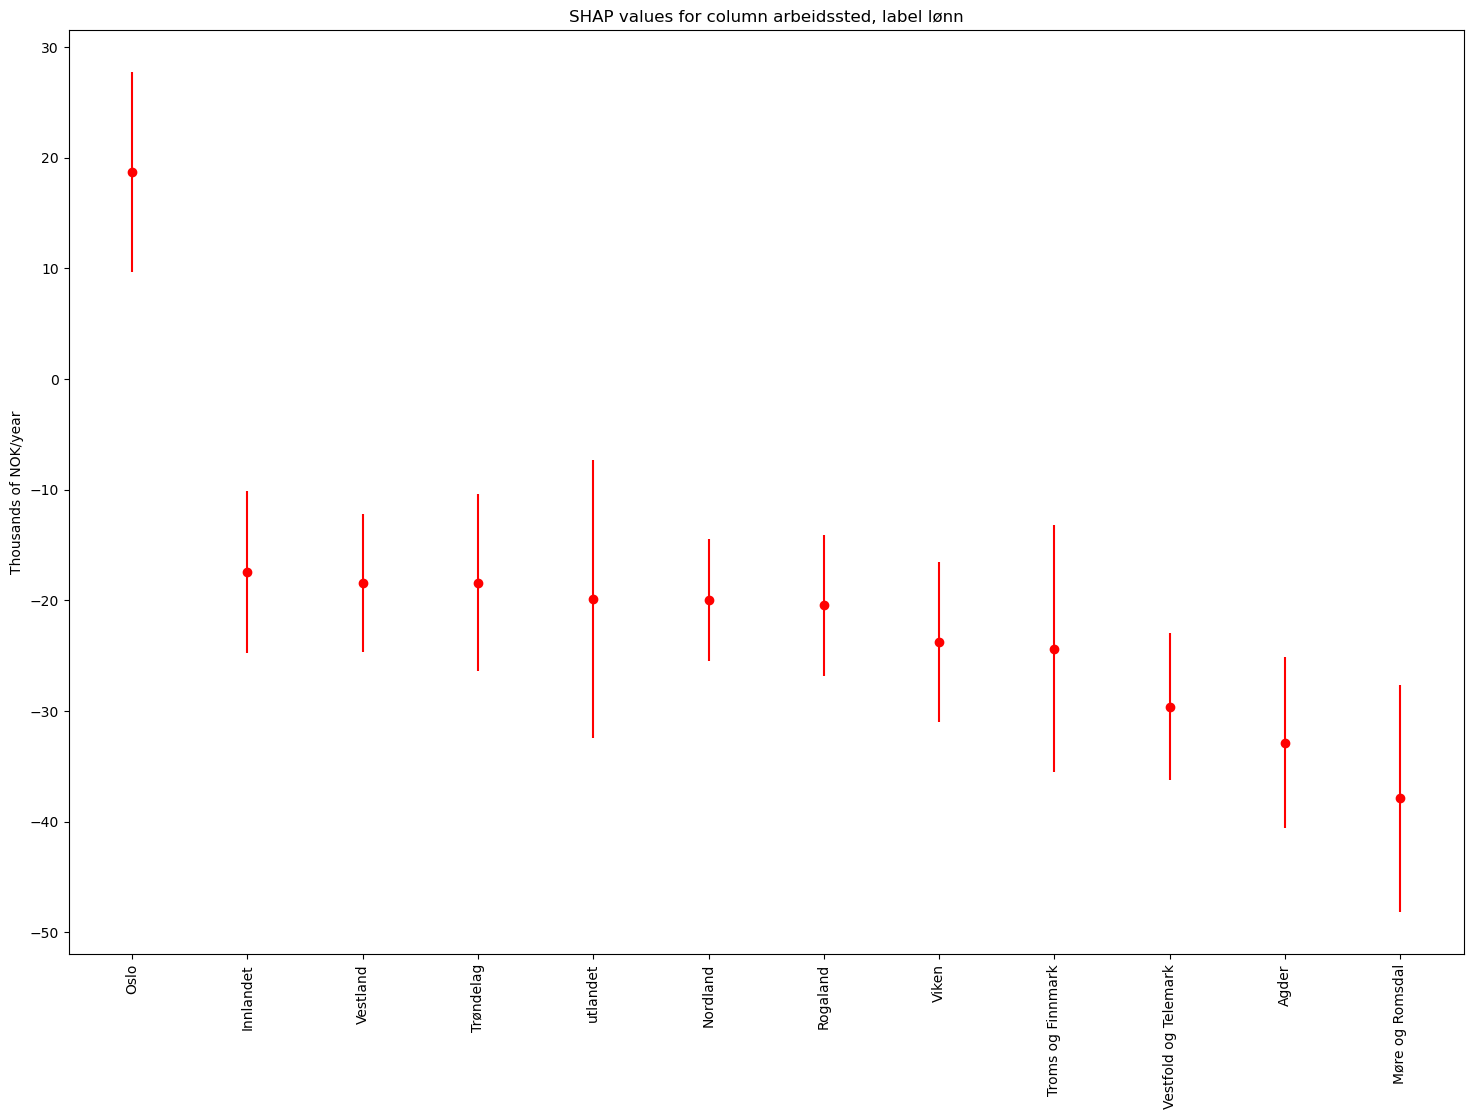

                         gain  gain_std  count
col                                           
Oslo                  18.7065    9.0274    700
Innlandet            -17.4316    7.2927     37
Vestland             -18.4152    6.2129    121
Trøndelag            -18.4182    8.0028     89
utlandet             -19.8943   12.5368     11
Nordland             -19.9977    5.5185     22
Rogaland             -20.4537    6.3828     75
Viken                -23.7582    7.2295     76
Troms og Finnmark    -24.3583   11.1748     17
Vestfold og Telemark -29.6004    6.6567     56
Agder                -32.8719    7.7447     40
Møre og Romsdal      -37.9111   10.2866     19

arbeidssituasjon



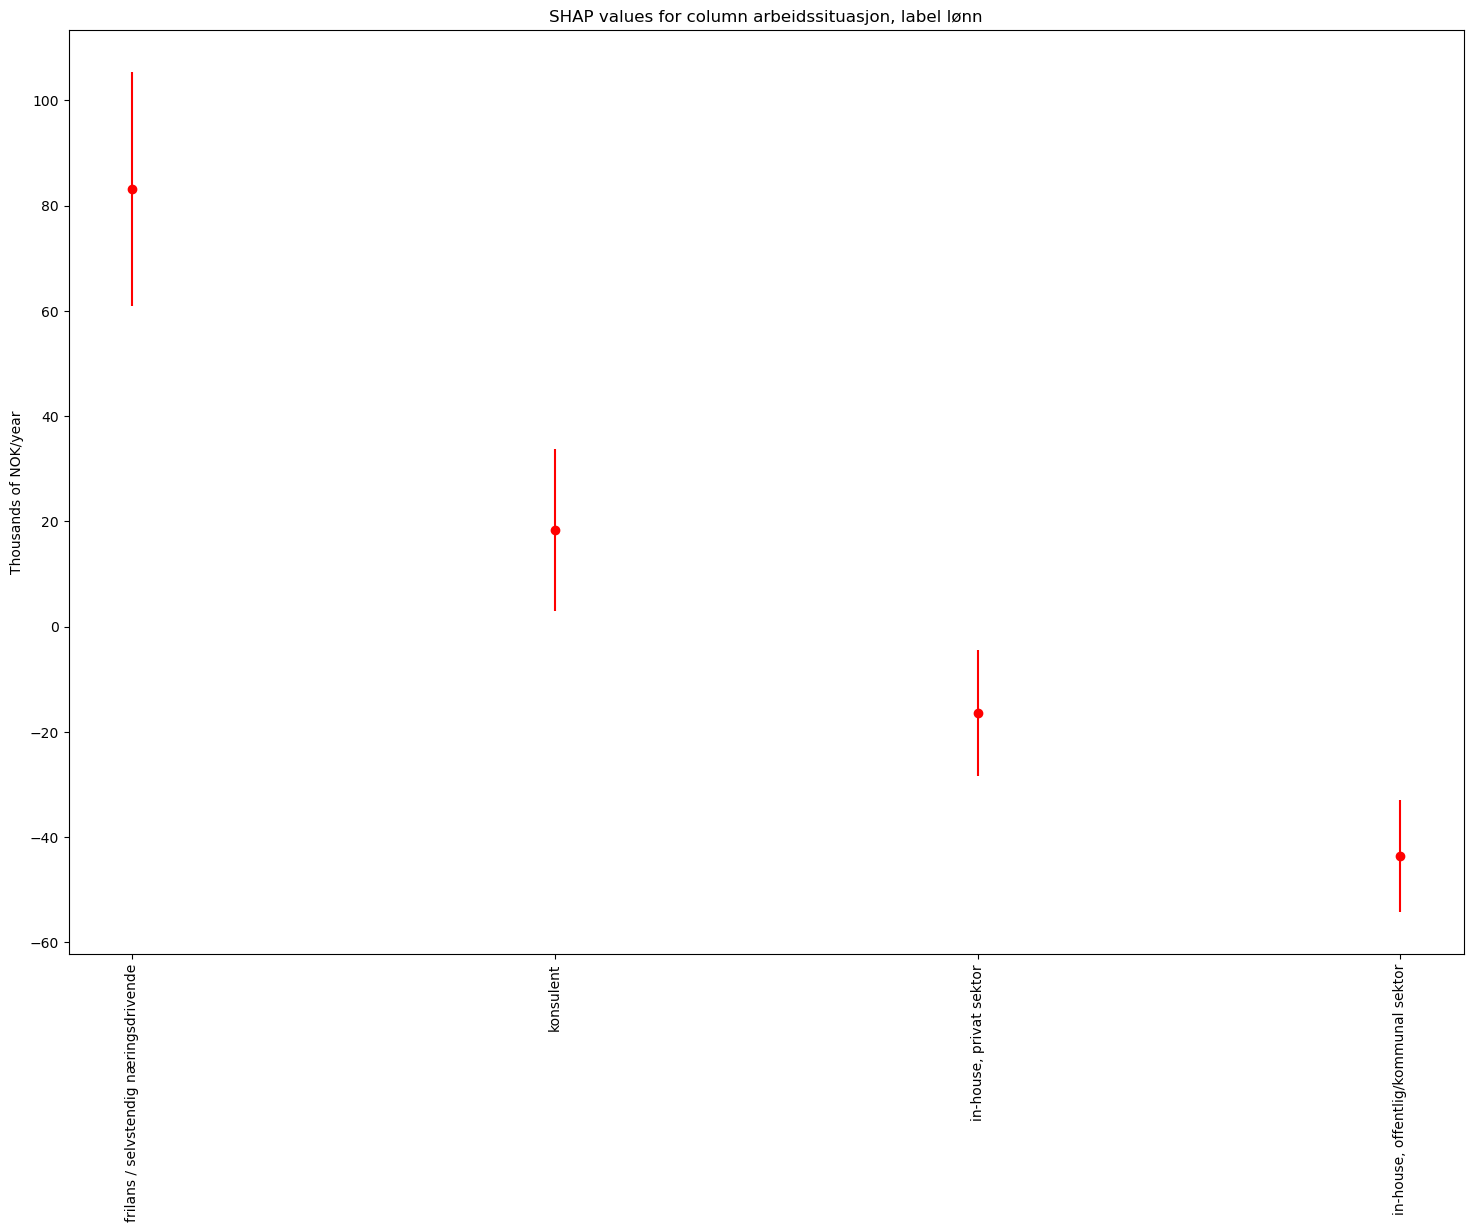

                                          gain  gain_std  count
col                                                            
frilans / selvstendig næringsdrivende  83.1698   22.2011     19
konsulent                              18.3186   15.4456    513
in-house, privat sektor               -16.3406   11.9564    576
in-house, offentlig/kommunal sektor   -43.6163   10.6173    155

fag



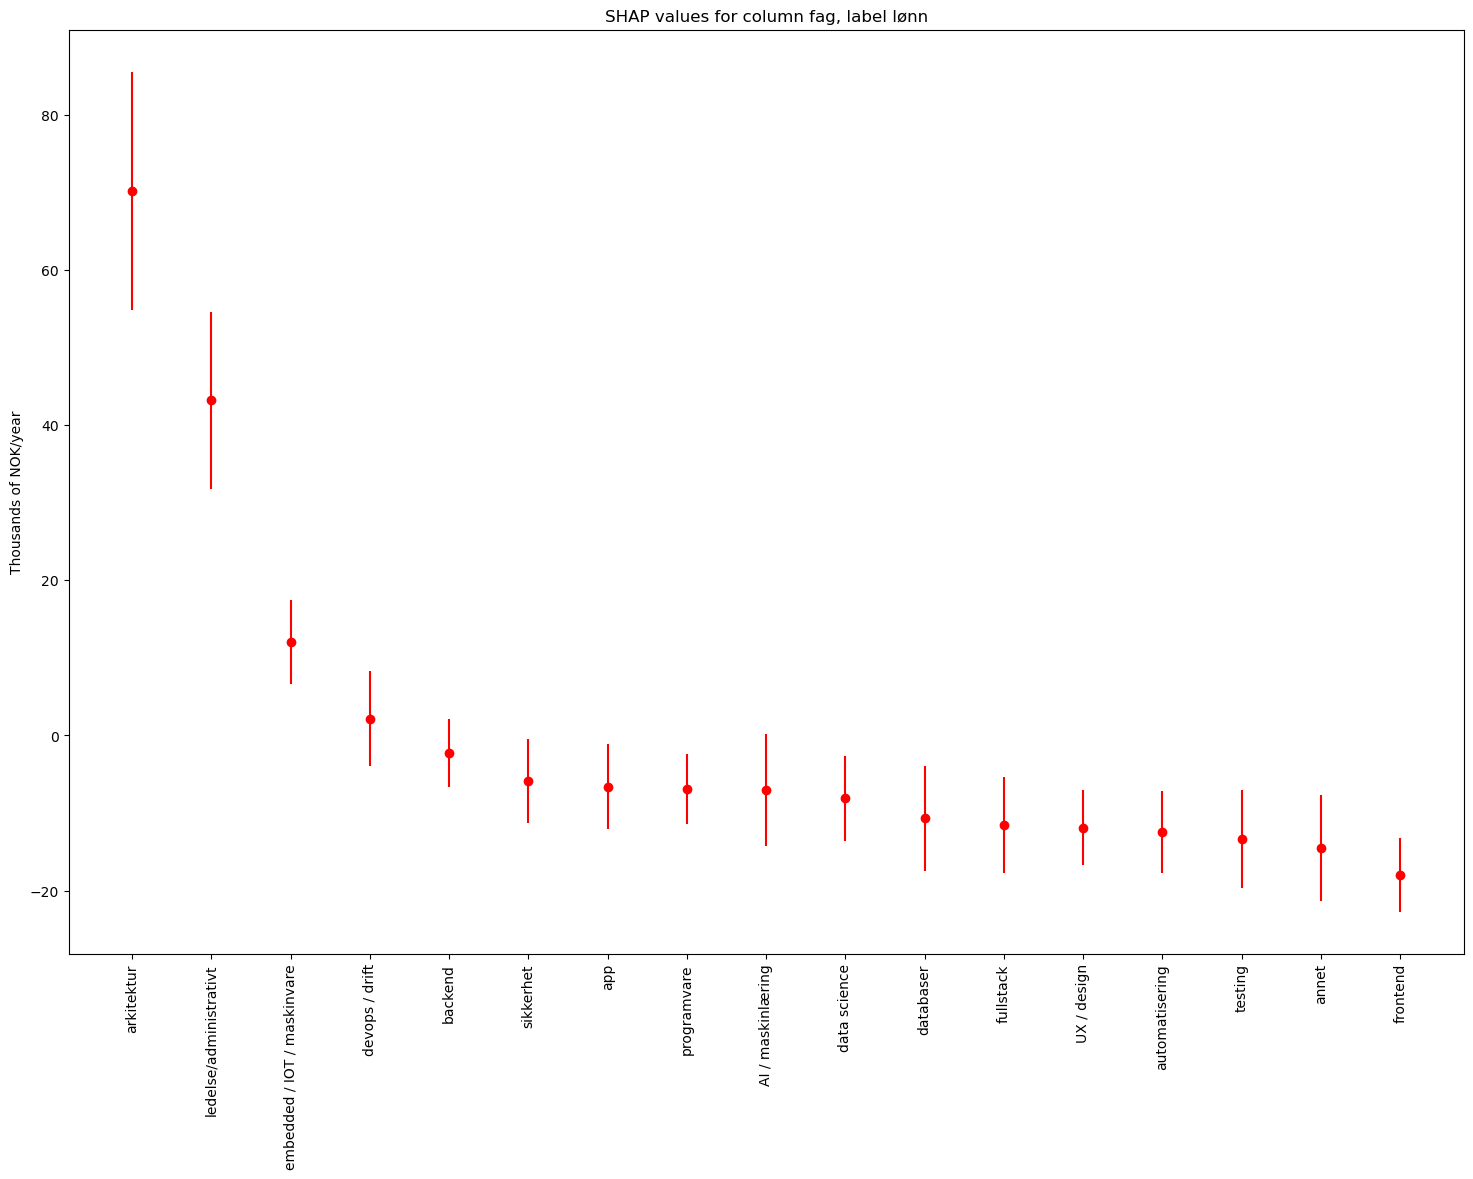

                                gain  gain_std  count
col                                                  
arkitektur                   70.1801   15.3545     53
ledelse/administrativt       43.1913   11.3795     69
embedded / IOT / maskinvare  12.0660    5.3768     10
devops / drift                2.1804    6.1833     67
backend                      -2.2851    4.3987    267
sikkerhet                    -5.8612    5.3727     29
app                          -6.5834    5.5336     36
programvare                  -6.9282    4.5380     29
AI / maskinlæring            -7.0685    7.1990     11
data science                 -8.0851    5.4946     23
databaser                   -10.6909    6.7347     19
fullstack                   -11.5317    6.2215    420
UX / design                 -11.9261    4.8336     30
automatisering              -12.4679    5.2957     15
testing                     -13.3861    6.2994     15
annet                       -14.5359    6.8350     22
frontend                    

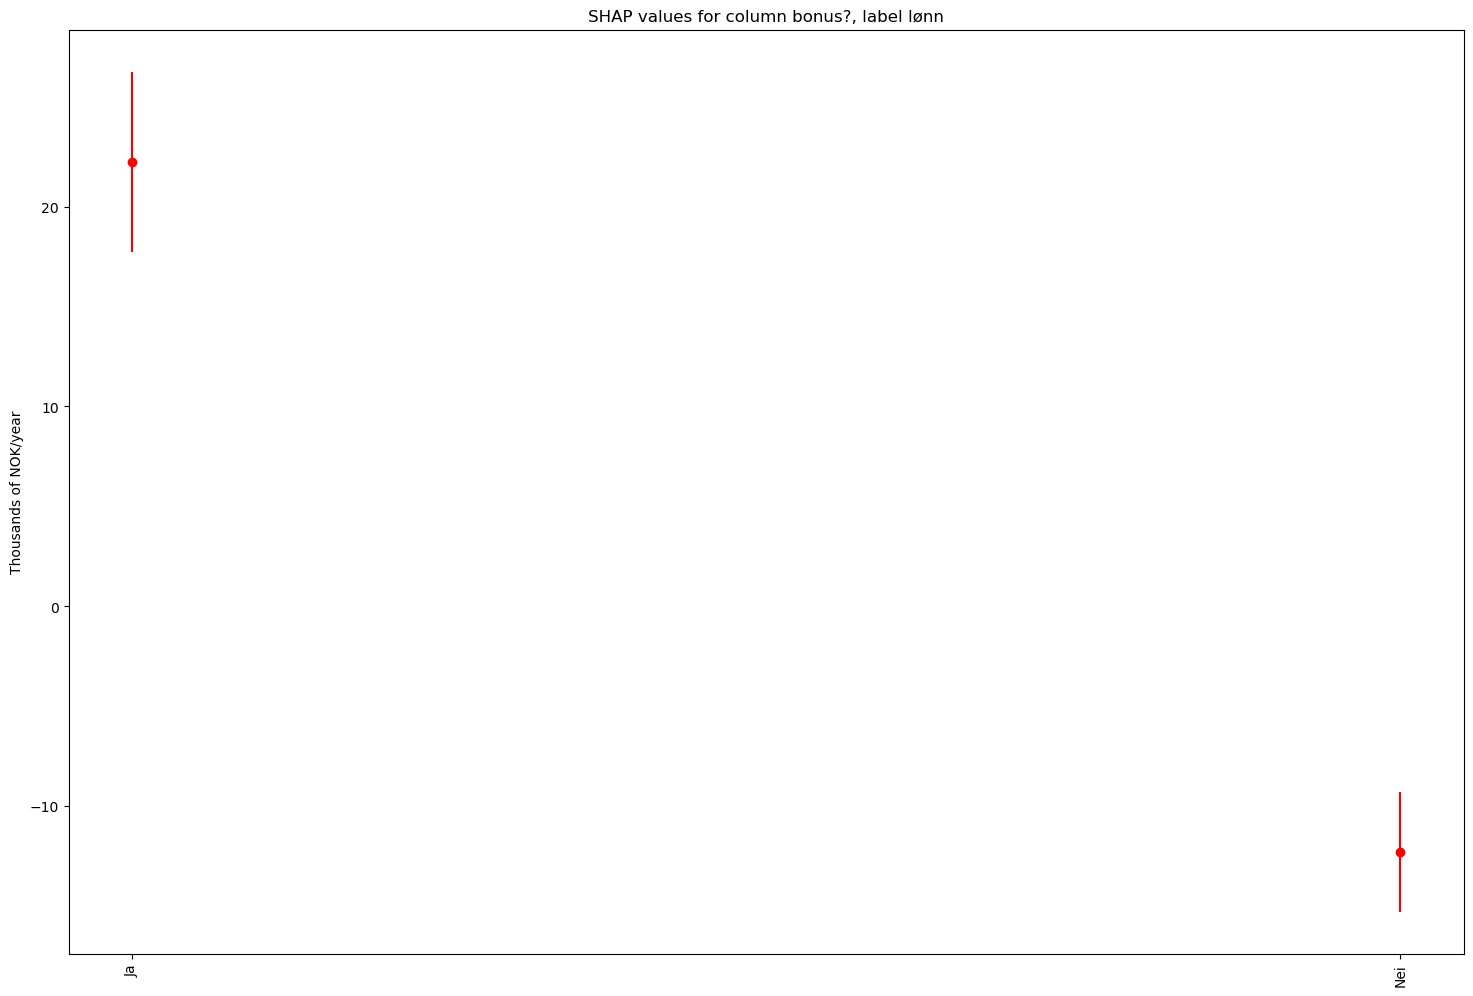

        gain  gain_std  count
col                          
Ja   22.2431    4.5201    387
Nei -12.2950    2.9854    876


In [16]:
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test, ylabel='points'):
    # Create a copy of the test data DataFrame.
    df_infl = X_test.copy()
    
    # Add a new column 'shap_' to the DataFrame containing SHAP values for the specified feature.
    df_infl['shap_'] = shap_values[:, df_infl.columns.tolist().index(col)]
    
    # Calculate the mean SHAP values and standard deviation grouped by the specified feature.
    gain = round(df_infl.groupby(col)['shap_'].mean(), 4)
    gain_std = round(df_infl.groupby(col)['shap_'].std(), 4)
    
    # Count the number of data points for each category of the specified feature.
    cnt = df_infl.groupby(col)['shap_'].count()
    
    # Create a dictionary containing the feature, mean SHAP values, standard deviation, and count.
    dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
        
    # Create a DataFrame from the dictionary and sort it by 'gain' in descending order.
    df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
    
    # Replace "$" by "*" to use in matplotlib
    if any([('$' in str(idx)) for idx in set(df_res.index)]):
        print('Replacing "$" by "*" to use in matplotlib')
        df_res.index = [c.replace('$','*') for c in df_res.index]
    
    if df_res['gain'].min() != df_res['gain'].max():
        # Create a plot to visualize the SHAP values with error bars.
        plt.figure(figsize=(18, 12))
        plt.errorbar(df_res.index, df_res['gain'].values, yerr=df_res['gain_std'].values, fmt="o", color="r")

        # Set plot title and axis labels.
        plt.title(f'SHAP values for column {col}, label {label}')
        plt.ylabel(ylabel)
        plt.tick_params(axis="x", rotation=90)

        # Display the plot and the DataFrame with results.
        plt.show()
        print(df_res)
    
    # Return the function.
    return

# Loop through the columns in the test data.
for col in X_test.columns:
    print()  # Print an empty line for better readability.
    print(col)  # Print the name of the current column.
    print()  # Print another empty line for separation.

    # Call the 'show_shap' function to visualize SHAP values for the current column.
    show_shap(col, shap_values, label=main_label, X_test=X_test, ylabel='Thousands of NOK/year')
